In [1]:
import pydot #remember to install graphviz on your system as well!
import os
from IPython.display import Image, display

In [2]:
BEARD_PIC_FOLDER = './alt_pictures/new_asian/'

# Create graph of beards

In [3]:
dot_graph = pydot.Dot(graph_type='digraph') # visualization graph
node_dict = {} # dict of nodes {node_name: pydot.Node}
graph = {} # dict of edges {parent_node: list(child_node1, child_node2, ... , child_nodeK)}

#### Make each node from a beard type

Iterate through all the beard images in 'beard_pictures' by assuming all PNG files are beard images. 

Create an image node for each of these beards.

In [4]:
files = os.listdir(BEARD_PIC_FOLDER)
for file_name in files:
    if not file_name.endswith('jpg'): 
        continue
    # dot freaks out if you don't provide absolute paths...
    file_path = os.path.abspath(os.path.join(BEARD_PIC_FOLDER, file_name))
    with open(file_path) as beardpic:
        node_name = file_name[:-4]  # remove .png        
        n = pydot.Node(node_name, image=file_path, shape='box', label='\n')
        dot_graph.add_node(n)
        node_dict[node_name] = n

#### Make each "can shave to" edge between beard types

Read in the pairs in *final_pairs_v3.csv*.
Each line contains an edge in the graph. First entry is parent, second is child.

In [5]:
graph['federationstandard'] = [] # sink of beard path
with open('./beard_precedence_lists/final_pairs_v3.csv','rU') as beard_pairs:
    for line in beard_pairs:
        parent, child = line.strip().split(',')
        
        # add to visualization graph
        dot_graph.add_edge(pydot.Edge(node_dict[parent], node_dict[child]))
        
        # add to our personal processing graph
        children = graph.get(parent,[])
        children.append(child)
        graph[parent] = children

Write out graph

In [6]:
dot_graph.write_dot('beard_graph.dot')
dot_graph.write_pdf('beard_graph.pdf')
dot_graph.write_png('beard_graph.png')

True

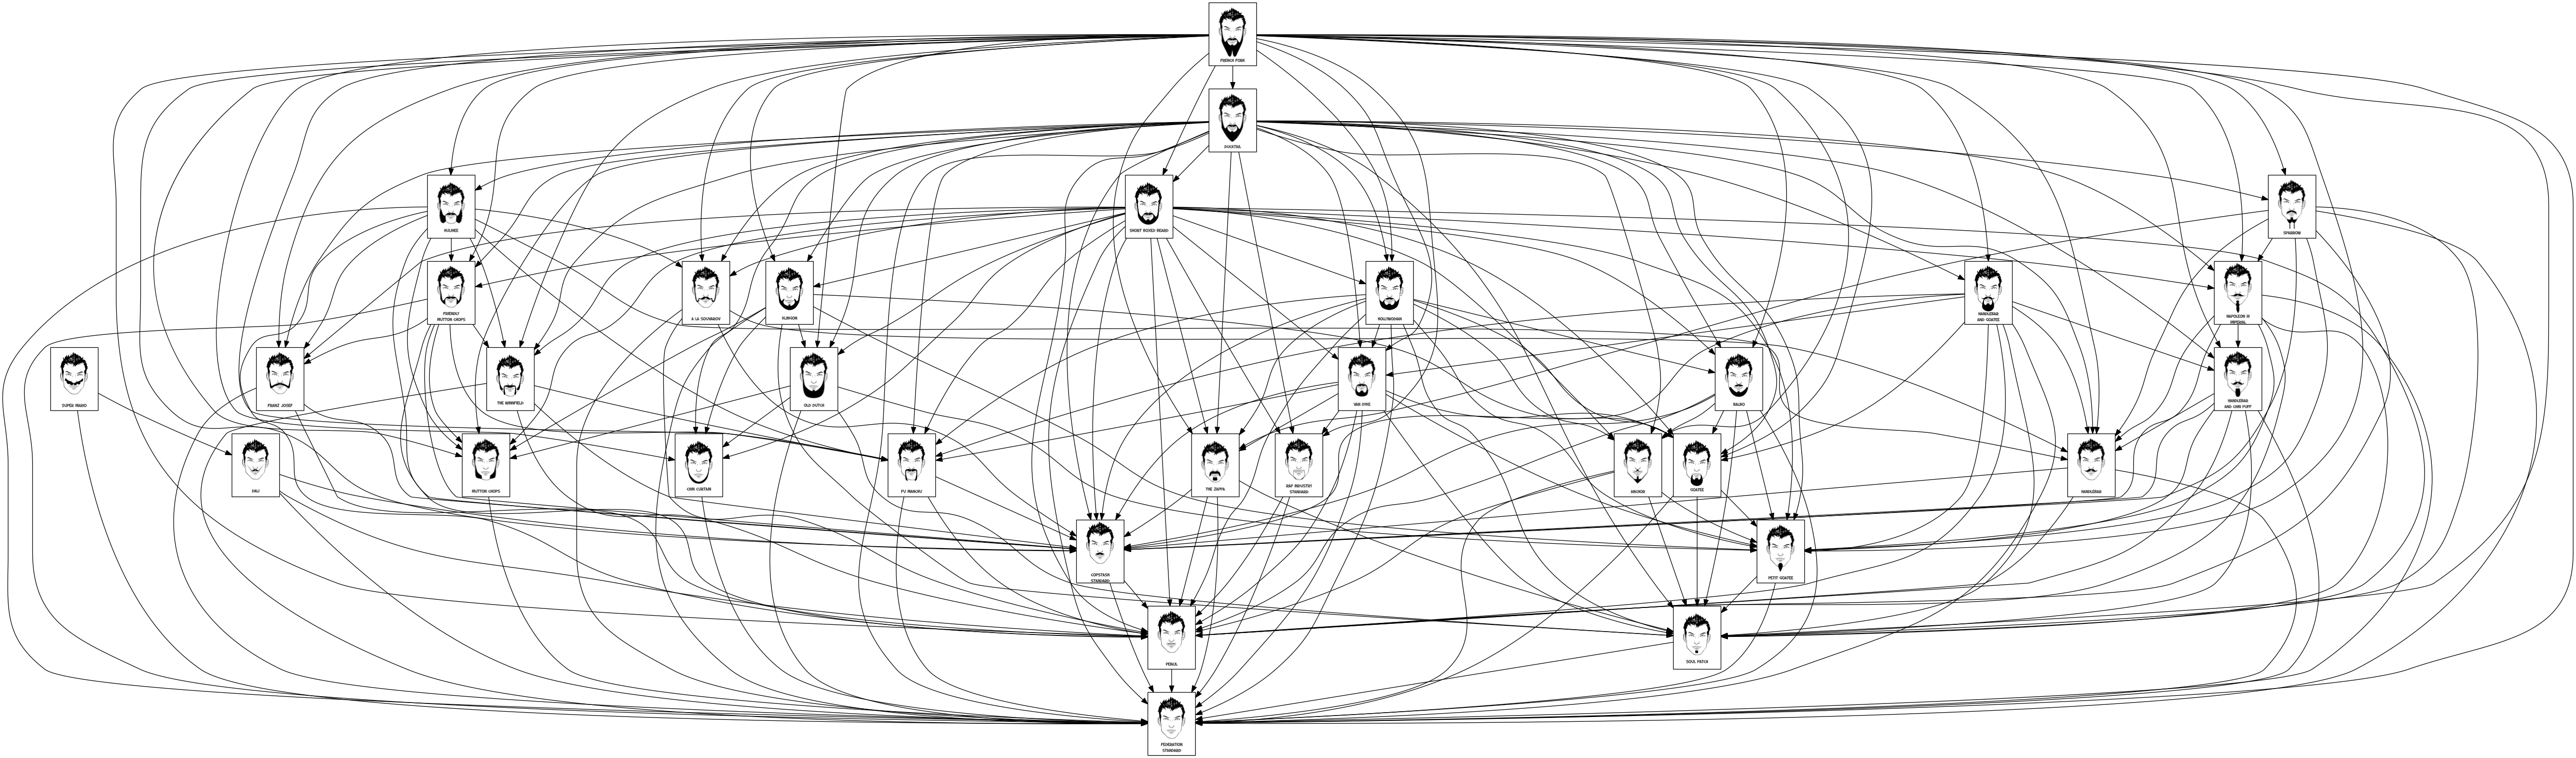

In [7]:
display(Image(filename='beard_graph.png'))

# Find longest path in beard graph

Starting at full beard (shortboxedbeard) and ending at clean shaven (federationstandard), we find the longest path in an equal edge cost graph. 

In [8]:
START_NODE = 'shortboxedbeard'
END_NODE = 'federationstandard'

Forward pass through graph. Updates the parent of a child if the path to this child is longer than any other paths to the child

In [9]:
fringe = [START_NODE]
pointer_scores = {} # dict{nodename: list(score, [list of parents to make this score])}


for node in graph:
    pointer_scores[node] = [1,[]] 
    
while len(fringe) > 0:
    cur_node = fringe.pop(0)
    children = graph[cur_node]
    new_score = pointer_scores[cur_node][0] + 1
    
    for child in children:
        p = pointer_scores[child]
        # if we found a higher score path, update teh pointer_scores
        if new_score > p[0]:
            p[0] = new_score
            p[1] = [cur_node]
            
        # if equal value path, add this parent to the list
        elif new_score == [child]:
            p[1].append(cur_node)
            
        # bad path
        else:
            continue
        
        # this only works because DAG has no loops. Otherwise it would infinitely recurse
        if child not in fringe:
            fringe.append(child)

Now backtrack on parents to retreive longest path(s)

In [10]:
paths = []
# returns list of paths
def backtrack(node_name):
    if node_name == START_NODE:
        return [[START_NODE]]
    parents = pointer_scores[node_name][1]
    path_list = []
    for parent in parents:
        for parent_path in backtrack(parent):
            path_list.append(parent_path + [node_name])
    return path_list

Create images of all backtracked paths

In [14]:
dot_graphs = []
graph_fnames = []
for path_num, path in enumerate(backtrack(END_NODE)):
    path_graph = pydot.Dot(graph_type='digraph')
    for node_num, node in enumerate(path):
        path_graph.add_node(node_dict[node])
        if node_num != 0:
            path_graph.add_edge(pydot.Edge(node_dict[path[node_num-1]], node_dict[node]))
            
    dot_graphs.append(path_graph)
    fname = 'optimal_beard_path_%s.png' % path_num
    path_graph.write_png(fname)
    graph_fnames.append(fname)

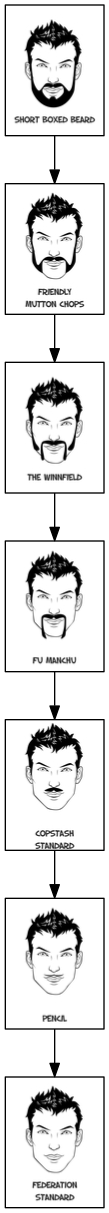

In [16]:
display(Image(filename=fname))